In [1]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skl

client = pymongo.MongoClient()
db = client.VentDyssynchrony_db
ventSettings = db.VentSettings_collection
breathData = db.BreathData_collection
RT = db.RTData_collection
RN = db.RNData_collection
patient = db. PatientData_collection

%matplotlib inline

In [79]:
def custom_resampler(dict_like):
    return dict_like['analysis.' + ds_types].sum(), dict_like['breath_number'].count(), dict_like['patientID'].max(), \
           dict_like['vent_settings.FiO2'].mean(), dict_like['vent_settings.PEEP'].mean(), \
           dict_like['vent_settings.compliance'].mean(), dict_like['vent_settings.p_peak'].mean(), \
           dict_like['vent_settings.set_VT'].mean()


def bin_samples(x):
    if x <= 0.05:
        return 0
    elif x == np.nan:
        return np.nan
    elif x > 0.05:
        return 1


def unpack(x):
    fio2 = np.nan
    set_vt = np.nan
    peep = np.nan

    for items in x:
        for keys, values in items.items():
            if keys == 'FiO2':
                fio2 = values
            elif keys == 'Set Vt':
                set_vt = values
            elif keys == 'PEEP':
                peep = values

    return (fio2, peep, set_vt)

In [3]:
breathData.find().count()

1817239

In [4]:
patient_df = pd.read_csv('C:\Research_data\Demographic Data v2.csv', engine = 'c',
                             usecols = ['Study ID', 'NMB', 'Start_End_NMB'])
patient_df.set_index(['Study ID'], inplace = True)
patient_df.head(15)

,NMB,Start_End_NMB
Study ID,,
100,No,NaN
101,No,NaN
102,No,NaN
103,No,NaN
104,Yes,"7/6/14 17:00, 7/7/14 21:00"
105,No,NaN
106,No,NaN
107,No,NaN
108,No,NaN


In [5]:
patient_df['Start_End_NMB'].ix[125]


'7/5/15 13:00, 7/10/15 09:00'

In [6]:
ds_types = 'ds'

In [7]:
    data = breathData.find({},
                           {'patientID': 1, 'start_time': 1, 'breath_number': 1, 'vent_settings.PEEP': 1,
                            'vent_settings.FiO2': 1, 'vent_settings.compliance': 1, 'vent_settings.set_VT': 1,
                            'vent_settings.p_peak': 1, 'analysis.' + ds_types: 1, '_id': 0})

    rn = RN.find({'RN_entry.FiO2': {'$exists': 1}},
                 {'patientID': 1, 'entry_time': 1, 'RN_entry.FiO2': 1, 'RN_entry.PEEP': 1, 'RN_entry.Set Vt': 1,
                  '_id': 0})

    rt = RT.find({'RT_entry.FiO2': {'$exists': 1}},
                 {'patientID': 1, 'entry_time': 1, 'RT_entry.FiO2': 1, 'RT_entry.PEEP': 1, 'RT_entry.Set Vt': 1,
                  '_id': 0})

In [8]:
    df = pd.io.json.json_normalize(data)
    df['start_time'] = pd.to_datetime(df['start_time'])
    df.drop_duplicates(subset = 'start_time', keep = 'last', inplace = True)
    df.set_index(['patientID', 'start_time'], inplace = True, verify_integrity = True, drop = False)
    df.sort_index(inplace = True)
    df['vent_settings.PEEP'] = df['vent_settings.PEEP'].astype(np.float64)
    df['breath_number'] = df['breath_number'].astype(np.float64)
    df['analysis.' + ds_types] = df['analysis.' + ds_types].astype(np.float64)

    print('Pre ', df.shape)



Pre  (1814900, 9)


In [9]:
    rt_df = pd.io.json.json_normalize(list(rt))
    rn_df = pd.io.json.json_normalize(list(rn))

    rt_df['temp'] = rt_df.RT_entry.apply(unpack)
    rt_df['vent_settings.FiO2'] = rt_df['temp'].apply(lambda x: x[0])
    rt_df['vent_settings.PEEP'] = rt_df['temp'].apply(lambda x: x[1])
    rt_df['vent_settings.set_VT'] = rt_df['temp'].apply(lambda x: x[2])
    rt_df.drop(['RT_entry', 'temp'], inplace = True, axis = 1)

    rn_df['temp'] = rn_df.RN_entry.apply(unpack)
    rn_df['vent_settings.FiO2'] = rn_df['temp'].apply(lambda x: x[0])
    rn_df['vent_settings.PEEP'] = rn_df['temp'].apply(lambda x: x[1])
    rn_df['vent_settings.set_VT'] = rn_df['temp'].apply(lambda x: x[2])
    rn_df.drop(['RN_entry', 'temp'], inplace = True, axis = 1)

    rt_df.set_index(['patientID', 'entry_time'], inplace = True)
    rn_df.set_index(['patientID', 'entry_time'], inplace = True)

    final = rt_df.combine_first(rn_df)
    final.index.set_names(['patientID', 'start_time'], inplace = True)

    df = df.combine_first(final)
    df.set_index(['start_time'], inplace = True)

    print('Post ', df.shape)
    print(df.columns)

 

Post  (1816616, 8)
Index(['analysis.ds', 'breath_number', 'patientID', 'vent_settings.FiO2',
       'vent_settings.PEEP', 'vent_settings.compliance',
       'vent_settings.p_peak', 'vent_settings.set_VT'],
      dtype='object')


In [80]:
    grouped_df = df.groupby('patientID')

    resampled_df = pd.DataFrame()
    for name, group in grouped_df:       
        group = group.resample('2H', how = custom_resampler)
        group['NMB'] = 0
        
        patient_info = patient_df.ix[int(name.strip('P'))]
        if patient_info['NMB'] == 'Yes':
            start_stop = patient_info['Start_End_NMB'].strip('[]').split(';')

            for items in start_stop:
                start, stop = items.strip('()').split(',')
                start = pd.to_datetime(start)
                stop = pd.to_datetime(stop)
                
                if start < stop:
                    group.loc[(group.index >= start) & (group.index <= stop), 'NMB'] = 1
                else:
                    rn_df.loc[(group.index >= stop) & (group.index <= start), 'NMB'] = 1
        group['NMB_sum'] = pd.rolling_sum(group['NMB'], window=18, center=False)        
        #print(group[['NMB_sum', 'NMB']])
        
        try:
            group['ds_freq'] = group['analysis.' + ds_types] / group['breath_number']
        except ZeroDivisionError:
            print(group['analysis.' + ds_types, 'breath_number'])

        for lags in [12, 18, 24]:
            for items in ['ds', 'FiO2', 'PEEP', 'p_peak', 'set_VT']:
                if items == 'ds':
                    group[items + '_lag_' + str(lags)] = np.nan
                    group[items + '_lag_' + str(lags)] = group['ds_freq'].shift(lags)
                    group[items + '_lag_' + str(lags)] = group[items + '_lag_' + str(lags)].astype(np.float64)
                else:
                    group[items + '_diff_lag_' + str(lags)] = group['vent_settings.' + items] - group[
                        'vent_settings.' + items].shift(lags)
                    
            group['NMB_lag'+str(lags)] = 0
            group['NMB_lag'+str(lags)] = group['NMB_sum'].shift(lags)
            
        resampled_df = pd.concat([resampled_df, group])
    resampled_df.NMB_lag18[resampled_df.NMB_lag18 >0].describe()

 

count    122.000000
mean      11.959016
std        6.032142
min        1.000000
25%        7.000000
50%       12.000000
75%       18.000000
max       18.000000
Name: NMB_lag18, dtype: float64

In [81]:
resampled_df.describe()

,analysis.ds,breath_number,vent_settings.FiO2,vent_settings.PEEP,vent_settings.compliance,vent_settings.p_peak,vent_settings.set_VT,NMB,NMB_sum,ds_freq,...,PEEP_diff_lag_18,p_peak_diff_lag_18,set_VT_diff_lag_18,NMB_lag18,ds_lag_24,FiO2_diff_lag_24,PEEP_diff_lag_24,p_peak_diff_lag_24,set_VT_diff_lag_24,NMB_lag24
count,928.000000,928.000000,742.000000,742.000000,740.000000,742.000000,579.000000,928.000000,535.000000,745.000000,...,323.000000,323.000000,183.000000,290.000000,314.000000,253.000000,253.000000,253.000000,140.000000,241.000000
mean,51.933190,1955.711207,54.310569,8.422606,53.309204,22.889168,415.066879,0.174569,3.405607,0.028903,...,-0.332421,-0.815107,1.065734,5.031034,0.033788,-4.765638,-0.190104,-1.058266,0.015918,5.863071
std,108.199793,1274.601741,17.759305,2.929940,33.822077,6.195661,75.894508,0.379803,6.261018,0.058193,...,2.585507,5.347440,37.306344,7.085909,0.073980,15.969524,2.415937,5.549162,49.296364,7.419142
min,0.000000,0.000000,30.000000,0.876777,15.133578,4.000000,270.000000,0.000000,0.000000,0.000000,...,-9.000000,-14.371918,-110.000000,0.000000,0.000000,-60.000000,-6.000000,-18.268650,-110.227801,0.000000
25%,0.000000,838.750000,40.000000,5.000000,30.094261,18.427871,370.000000,0.000000,0.000000,0.001412,...,-2.000000,-3.871750,0.000000,0.000000,0.000780,-10.000000,-1.837072,-4.747693,0.000000,0.000000
50%,8.000000,2276.000000,50.000000,8.000000,41.824503,22.859459,420.000000,0.000000,0.000000,0.007673,...,0.000000,-0.440706,0.000000,0.000000,0.006822,0.000000,0.000000,-0.936197,0.000000,0.000000
75%,45.250000,2887.000000,60.000000,10.000000,66.412446,27.459194,470.000000,0.000000,3.000000,0.031187,...,1.132890,2.070784,0.000000,10.000000,0.033577,0.000000,0.423297,2.083956,0.000000,12.000000
max,922.000000,4539.000000,100.000000,20.000000,181.382775,41.406943,630.000000,1.000000,18.000000,1.000000,...,6.000000,14.888697,160.000000,18.000000,1.000000,50.000000,6.000000,13.046730,160.000000,18.000000


In [82]:
    resampled_df.dropna(how = 'any', subset = ['vent_settings.FiO2'], inplace = True)
    resampled_df.replace({0: np.nan}, inplace = True)

    for times in ['12', '18', '24']:
        resampled_df['ds_lag_' + times + '_bin'] = resampled_df['ds_lag_' + times].apply(bin_samples)

    resampled_df.to_csv('c:\Research_data\lagged_analysis_2_' + ds_types + '.csv')

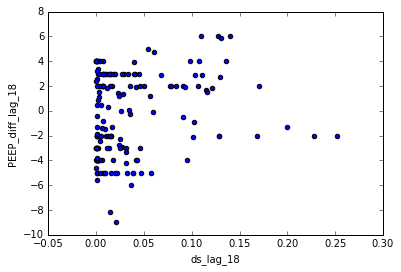

In [50]:
resampled_df.plot(x='ds_lag_18', y='PEEP_diff_lag_18', kind='scatter')

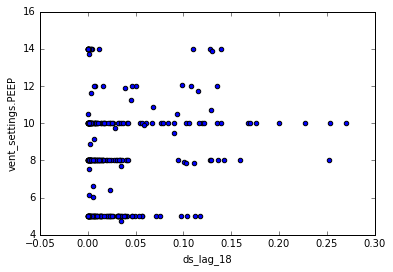

In [51]:
resampled_df.plot(x='ds_lag_18', y='vent_settings.PEEP', kind='scatter')

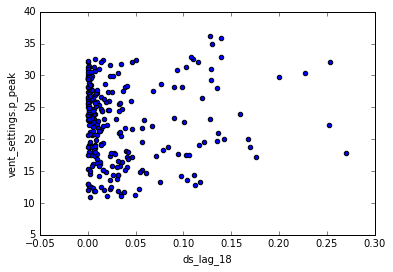

In [52]:
resampled_df.plot(x='ds_lag_18', y='vent_settings.p_peak', kind='scatter')

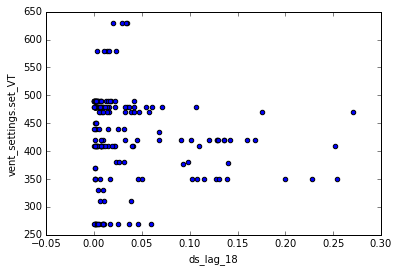

In [53]:
resampled_df.plot(x='ds_lag_18', y='vent_settings.set_VT', kind='scatter')

In [54]:
resampled_df[resampled_df['ds_lag_18'] > 0.05].describe()

,analysis.ds,breath_number,vent_settings.FiO2,vent_settings.PEEP,vent_settings.compliance,vent_settings.p_peak,vent_settings.set_VT,NMB,NMB_sum,ds_freq,...,NMB_lag18,ds_lag_24,FiO2_diff_lag_24,PEEP_diff_lag_24,p_peak_diff_lag_24,set_VT_diff_lag_24,NMB_lag24,ds_lag_12_bin,ds_lag_18_bin,ds_lag_24_bin
count,48.000000,55.000000,55.000000,55.000000,55.000000,55.000000,36.000000,14,14.000000,48.000000,...,0,31.000000,25.000000,20.000000,32.000000,13.000000,1,40.000000,55,31.000000
mean,163.145833,2333.854545,61.426643,9.306913,68.091479,23.142293,403.571502,1,8.142857,0.062736,...,NaN,0.045601,7.723326,1.537863,1.945800,-44.466349,4,0.350000,1,0.322581
std,220.072521,977.094093,16.603800,2.449732,50.244431,7.017315,50.513152,0,6.150136,0.070706,...,NaN,0.050174,23.273440,3.182987,7.154104,36.213225,NaN,0.483046,0,0.475191
min,1.000000,1.000000,40.000000,5.000000,16.123847,12.170987,270.000000,1,1.000000,0.000925,...,NaN,0.000468,-40.124964,-4.000000,-12.801438,-70.000000,4,0.000000,1,0.000000
25%,10.000000,1605.000000,50.000000,8.000000,23.035677,17.611031,350.000000,1,2.250000,0.005816,...,NaN,0.007810,-10.000000,-0.582154,-2.692090,-70.000000,4,0.000000,1,0.000000
50%,37.500000,2467.000000,60.000000,10.000000,57.896870,22.027893,420.000000,1,7.000000,0.027510,...,NaN,0.029150,10.000000,1.959632,2.830343,-70.000000,4,0.000000,1,0.000000
75%,304.750000,3176.500000,70.000000,10.000000,96.485579,29.498664,420.000000,1,13.750000,0.113269,...,NaN,0.067986,21.029594,4.000000,8.463599,-10.723665,4,1.000000,1,1.000000
max,922.000000,3645.000000,100.000000,14.000000,170.987013,36.153056,480.000000,1,17.000000,0.253785,...,NaN,0.176000,47.225000,6.000000,13.000000,14.190920,4,1.000000,1,1.000000


In [55]:
resampled_df[resampled_df['ds_lag_18'] <= 0.05].describe()

,analysis.ds,breath_number,vent_settings.FiO2,vent_settings.PEEP,vent_settings.compliance,vent_settings.p_peak,vent_settings.set_VT,NMB,NMB_sum,ds_freq,...,NMB_lag18,ds_lag_24,FiO2_diff_lag_24,PEEP_diff_lag_24,p_peak_diff_lag_24,set_VT_diff_lag_24,NMB_lag24,ds_lag_12_bin,ds_lag_18_bin,ds_lag_24_bin
count,194.000000,220.000000,220.000000,220.000000,219.000000,220.000000,149.000000,24,56.000000,194.000000,...,46.000000,120.000000,98.000000,78.000000,150.000000,23.000000,46.000000,164.000000,220,120.00000
mean,40.103093,2372.981818,48.991826,8.204956,57.883177,22.569091,434.427545,1,10.678571,0.017295,...,10.608696,0.028205,-6.565199,-0.226422,-0.991135,-0.381648,10.239130,0.182927,0,0.17500
std,80.019814,883.626277,13.279949,2.663341,37.034599,5.828959,84.223567,0,5.815675,0.030374,...,6.133617,0.043205,16.845914,3.031645,5.389410,97.992898,5.696723,0.387791,0,0.38156
min,1.000000,1.000000,30.000000,4.740803,15.133578,11.000000,270.000000,1,1.000000,0.000297,...,1.000000,0.000297,-60.000000,-6.000000,-18.268650,-110.227801,1.000000,0.000000,0,0.00000
25%,6.000000,1877.000000,40.000000,5.000000,35.227736,17.868066,410.000000,1,5.750000,0.002406,...,5.250000,0.001838,-12.763389,-3.000000,-4.437085,-70.000000,5.000000,0.000000,0,0.00000
50%,17.000000,2588.000000,40.264424,8.000000,44.784998,23.686273,470.000000,1,11.500000,0.006836,...,10.500000,0.009535,-10.000000,0.198149,-0.458327,-50.000000,10.000000,0.000000,0,0.00000
75%,38.750000,2981.250000,60.000000,10.000000,69.177575,27.100124,480.000000,1,17.250000,0.017511,...,18.000000,0.031594,10.000000,2.000000,2.198401,70.000000,17.250000,0.000000,0,0.00000
max,715.000000,4342.000000,100.000000,14.000000,181.382775,32.610453,630.000000,1,18.000000,0.227635,...,18.000000,0.203567,50.000000,5.000000,13.046730,160.000000,18.000000,1.000000,0,1.00000


In [56]:
def bin_samples(x):
    if x <=0.05: return 0
    elif x==np.nan: return np.nan
    elif x>0.05: return 1

for times in ['12', '18', '24']:
    resampled_df['ds_lag_'+times+'_bin'] = resampled_df['ds_lag_'+times].apply(bin_samples)

In [57]:
resampled_df.to_csv('c:\Research_data\lagged_analysis_2.csv')

In [22]:
import sklearn.preprocessing as skl

In [270]:
x = np.array([[1.,2.,3.,4.,5.]])
y = np.array([[1.,2.,3.,4.,5.]])

#xn = skl.normalize(x, 'l2')
#yn = skl.normalize(y, 'l2')

np.correlate(xn[0],yn[0], 'full')

array([ 0.        ,  0.09174698,  0.25689155,  0.4770843 ,  0.73397584,
        0.99086739,  0.69727705,  0.42203611,  0.18349396])

In [246]:
np.corrcoef(x, y)

array([[ 1.,  1.],
       [ 1.,  1.]])

In [247]:
np.corrcoef(xn,yn)

array([[ 1.,  1.],
       [ 1.,  1.]])

In [257]:
x = np.array([[1.,2.,3.,4.,5.]])
y = np.array([[6.,7.,8.,9.,10.]])

xn = skl.normalize(x, 'l2')
yn = skl.normalize(y, 'l2')

np.correlate(xn[0],yn[0], 'valid')

array([ 0.9649505])

In [249]:
np.corrcoef(xn, yn)

array([[ 1.,  1.],
       [ 1.,  1.]])

In [258]:
x = np.array([[1.,2.,3.,4.,5.]])
y = np.array([[1.,8.,9.,64.,125.]])

xn = skl.normalize(x, 'l2')
yn = skl.normalize(y, 'l2')

np.correlate(xn[0],yn[0], 'valid')

array([ 0.8849001])

In [251]:
np.corrcoef(xn, yn)

array([[ 1.        ,  0.90445752],
       [ 0.90445752,  1.        ]])

In [394]:
x = np.array([[0.,1.,2.,3.,4.,5.]])
y = np.array([[4.,3.,2.,1.,0.,0.]])

#xn = skl.normalize(x, 'l2')
#yn = skl.normalize(y, 'l2')

np.correlate(xn[0],yn[0], 'same')

array([ 0.0246183 ,  0.09847319,  0.24618298,  0.49236596,  0.73854895,
        0.83702214])

In [395]:
np.corrcoef(x, y)

array([[ 1.        , -0.98198051],
       [-0.98198051,  1.        ]])

In [292]:
skl.normalize(np.nan_to_num(np.array([[1,2,3,np.nan]])))

array([[ 0.26726124,  0.53452248,  0.80178373,  0.        ]])

In [291]:
np.dtype(np.int64)

dtype('int64')

In [400]:
db.collection_names()

['LabData_collection',
 'RTData_collection',
 'PatientData_collection',
 'VentSettings_collection',
 'LogData_collection',
 'TestData_collection',
 'ValidatedData_collection',
 'BreathData_collection',
 'RNData_collection']